In [1]:
import sqlite3
import pandas as pd
import numpy as np
import re
import string
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
conn = sqlite3.connect('../redditPosts.sqlite')
cur = conn.cursor()

## Get the list of existing subreddits in the database.

In [3]:
cur.execute('''SELECT subreddit FROM Posts GROUP BY subreddit ORDER BY (COUNT(id))''')
subreddits = list(map(lambda x: x[0], cur.fetchall()))

subreddits

['Superstonks',
 'finance',
 'options',
 'pennystocks',
 'amcstock',
 'GME',
 'CryptoCurrency',
 'dogecoin',
 'wallstreetbets']

In [4]:
for subreddit in subreddits:
    cur.execute('''SELECT AVG(score), COUNT(score), flag FROM
                    (SELECT B.score, (CASE
                                    WHEN B.body == '[deleted]' OR B.body == '[removed]' THEN 0
                                    ELSE 1
                                    END) AS flag
                    FROM PostBodyAndScore B
                    JOIN (SELECT id FROM Posts WHERE subreddit ==?) P
                    On P.id = B.id) comb
                    GROUP BY flag''', (subreddit,))

    print(subreddit,cur.fetchall())

Superstonks [(1.4615384615384615, 26, 0), (12.1, 120, 1)]
finance [(16.512359550561797, 445, 0), (49.87940705128205, 2496, 1)]
options [(5.675890340763515, 7806, 0), (27.118068996925878, 8783, 1)]
pennystocks [(5.620451248495324, 32399, 0), (72.21061123177164, 16115, 1)]
amcstock [(17.93377755244924, 41421, 0), (104.13195268489488, 80059, 1)]
GME [(45.454079474483066, 40189, 0), (137.4685982088646, 105408, 1)]
CryptoCurrency [(3.595744680851064, 282, 0), (67.27064220183486, 218, 1)]
dogecoin [(3.3076923076923075, 26, 0), (49.43283582089552, 67, 1)]
wallstreetbets [(18.386555853530623, 436651, 0), (248.8108802860313, 162220, 1)]


## Retrieve data from the database based on the subreddit.

In [5]:
subreddit = 'GME'
cmd = '''SELECT P.title, P.author, P.ext_link, P.created, B.body, B.score 
            FROM (SELECT * FROM Posts WHERE subreddit = '{}') P 
            JOIN PostBodyAndScore B
            On P.id = B.id
            WHERE B.body != "[removed]" AND B.body != "[deleted]"'''.format(subreddit)

df = pd.read_sql(cmd, conn)

In [6]:
df.head()

,title,author,ext_link,created,body,score
0,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqfajb/y...,1609786946,After watching this I took a position RIGHT AW...,6
1,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqvp7l/t...,1609841999,This guy explained exactly how to take a posit...,2
2,ICR conference (11th Jan),nicky94,https://www.reddit.com/r/GME/comments/krnthg/i...,1609939549,Any speculation or ideas on what Gamestop migh...,14
3,"GME is FINALLY going to the moon, this technic...",TitsDownOnly,https://www.reddit.com/r/GME/comments/kuo3w1/g...,1610315957,"After some downwards movement, I think everyb...",11
4,Ryan Cohen appointed to board!!!!?,nicky94,https://news.gamestop.com/news-releases/news-r...,1610368592,,18


In [11]:
df[df['score']> 576].shape
np.percentile(df_model['score'],95)
#df.shape

465.0

## Feature Engineering

In [10]:
df_model = df.copy()

df_model['Popular'] = 1*(df_model['score'] > np.percentile(df_model['score'], 95))

df_model.head()

,title,author,ext_link,created,body,score,Popular
0,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqfajb/y...,1609786946,After watching this I took a position RIGHT AW...,6,0
1,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqvp7l/t...,1609841999,This guy explained exactly how to take a posit...,2,0
2,ICR conference (11th Jan),nicky94,https://www.reddit.com/r/GME/comments/krnthg/i...,1609939549,Any speculation or ideas on what Gamestop migh...,14,0
3,"GME is FINALLY going to the moon, this technic...",TitsDownOnly,https://www.reddit.com/r/GME/comments/kuo3w1/g...,1610315957,"After some downwards movement, I think everyb...",11,0
4,Ryan Cohen appointed to board!!!!?,nicky94,https://news.gamestop.com/news-releases/news-r...,1610368592,,18,0


In [19]:
def emoji_count(s):
    s = ''.join(word.strip(string.punctuation) for word in s.split())
    return len(re.findall('[^\w\s,\(\)\'\/-]',s))

def hourOfDay(utc):
    return dt.datetime.utcfromtimestamp(utc).hour

def dayOfWeek(utc):
    return dt.datetime.utcfromtimestamp(utc).weekday()

def textLength(text):
    return len(text.split())

def postType(link):
    if not link:
        return 'others'
    if 'png' in link or 'jpg' in link:
        return 'figures'
    elif '/r/' in link:
        return 'others'
    else:
        return 'outside_link'

def countUpper(text):
    Up = 0
    Low = 0
    for ch in text:
        if ch.isupper():
            Up += 1
        elif ch.islower():
            Low += 1
    
    if Up + Low:
        return Up/(Up+Low)
    else:
        return 0
    
def exclamationAndQuestion(text):
    return text.count('!') + text.count('?')

def getMonth(utc):
    return dt.datetime.utcfromtimestamp(utc).month

def getAuthorInfo(author,created, df):
    df_author = df[df['author'] == author]
    df_prevHist = df_author[df_author['created'] < created]
    
    if df_prevHist.shape[0] == 0:
        return 0, 1
    
    log_post = np.log10(df_prevHist.shape[0])
    mean_upvotes = df_prevHist['score'].mean()
    
    return log_post, mean_upvotes
    
def primeTime(hour):
    primeTime = 1 if hour >= 7 and hour <= 11 else 0
    
    return primeTime

def weekend(day):
    return 1 if day >= 5 else 0

def featureProcessing(df_model):
    df_model['title_emoji'] = df_model['title'].apply(emoji_count)
    df_model['body_emoji'] = df_model['body'].apply(emoji_count)
    df_model['title_length'] = df_model['title'].apply(textLength)
    df_model['body_length'] = df_model['body'].apply(textLength)
    df_model['title_EQ'] = df_model['title'].apply(exclamationAndQuestion)
    df_model['body_EQ'] = df_model['body'].apply(exclamationAndQuestion)
    df_model['title_UL'] = df_model['title'].apply(countUpper)
    df_model['body_UL'] = df_model['body'].apply(countUpper)    
    df_model['hour'] = df_model['created'].apply(hourOfDay)
    df_model['day'] = df_model['created'].apply(dayOfWeek)
    df_model['post_type'] = df_model['ext_link'].apply(postType)
    df_model['prime_time'] = df_model['hour'].apply(primeTime)
    df_model['weekend'] = df_model['day'].apply(weekend)
    df_model['month'] = df_model['created'].apply(getMonth)
    
    for row in range(df_model.shape[0]):
        df_model.loc[row, ['log_num', 'mean_upvotes']] = getAuthorInfo(df_model.loc[row,'author'], df_model.loc[row,'created'], df_model)

    

In [20]:
featureProcessing(df_model)

In [21]:
df_model[['figures', 'outside_link']] = pd.get_dummies(df_model['post_type'])[['figures', 'outside_link']]

## Some exploratory data analysis on the features

### Effect of time and day

In [28]:
hots = np.zeros((7,24))

for hr in range(24):
    df_hour = df_model[df_model['hour'] == hr]
    for dy in range(7):
        hots[dy,hr] = df_hour[df_hour['day'] == dy].Popular.mean()

0.11046511627906977


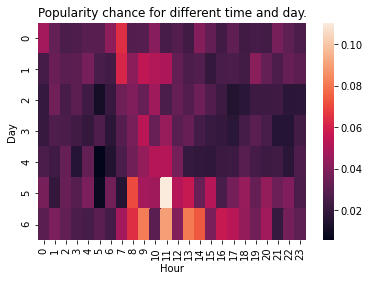

In [36]:
import seaborn as sns

ax = sns.heatmap(hots)
ax.set_title('Popularity chance for different time and day.')
ax.set_xlabel('Hour')
ax.set_ylabel('Day')
print(np.max(hots))

### Effect of Uppercase Proportion of the post

Text(0.5, 1.0, 'The proportion of uppercase letters in titles/bodies vs popular rate.')

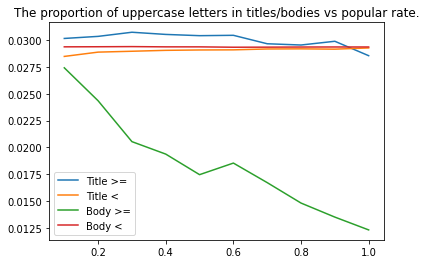

In [53]:
xx = np.linspace(0.1,1,10)

titlesL = []
titlesS = []
bodiesL = []
bodiesS = []

for x in xx:
    titlesL.append(df_model[df_model['title_UL'] >= x].Popular.mean())
    titlesS.append(df_model[df_model['title_UL'] < x].Popular.mean())
    bodiesL.append(df_model[df_model['body_UL'] >= x].Popular.mean())
    bodiesS.append(df_model[df_model['body_UL'] < x].Popular.mean())

    
plt.plot(xx,titlesL, label = 'Title >=')
plt.plot(xx,titlesS, label = 'Title <')
plt.plot(xx,bodiesL, label = 'Body >=')
plt.plot(xx,bodiesS, label = 'Body <')

plt.legend()
plt.title('The proportion of uppercase letters in titles/bodies vs popular rate.')

### Effect of Exclamation Points and Question Marks

Text(0.5, 1.0, 'The proportion of exclamation points/question marks in titles/bodies vs popular rate.')

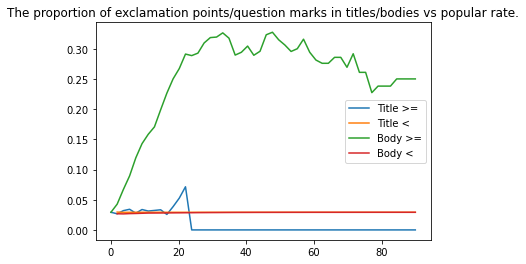

In [56]:
xx = np.linspace(0,90)

titlesL = []
titlesS = []
bodiesL = []
bodiesS = []

for x in xx:
    titlesL.append(df_model[df_model['title_EQ'] >= x].Popular.mean())
    titlesS.append(df_model[df_model['title_EQ'] < x].Popular.mean())
    bodiesL.append(df_model[df_model['body_EQ'] >= x].Popular.mean())
    bodiesS.append(df_model[df_model['body_EQ'] < x].Popular.mean())

    
plt.plot(xx,titlesL, label = 'Title >=')
plt.plot(xx,titlesS, label = 'Title <')
plt.plot(xx,bodiesL, label = 'Body >=')
plt.plot(xx,bodiesS, label = 'Body <')

plt.legend()
plt.title('The proportion of exclamation points/question marks in titles/bodies vs popular rate.')

### Check the feasibility of splitting the training/testing set by time

In [22]:

df_model_TrAiN = df_model[df_model['month'] < 4]
df_model_TeSt = df_model[df_model['month'] >= 4]

df_model_TeSt.head()

print(df_model_TrAiN.Popular.count())

print(df_model_TeSt.Popular.count())

76718
28690


### Check if the three features of Twitter are useful, and whether they are mutually redundant.

37396

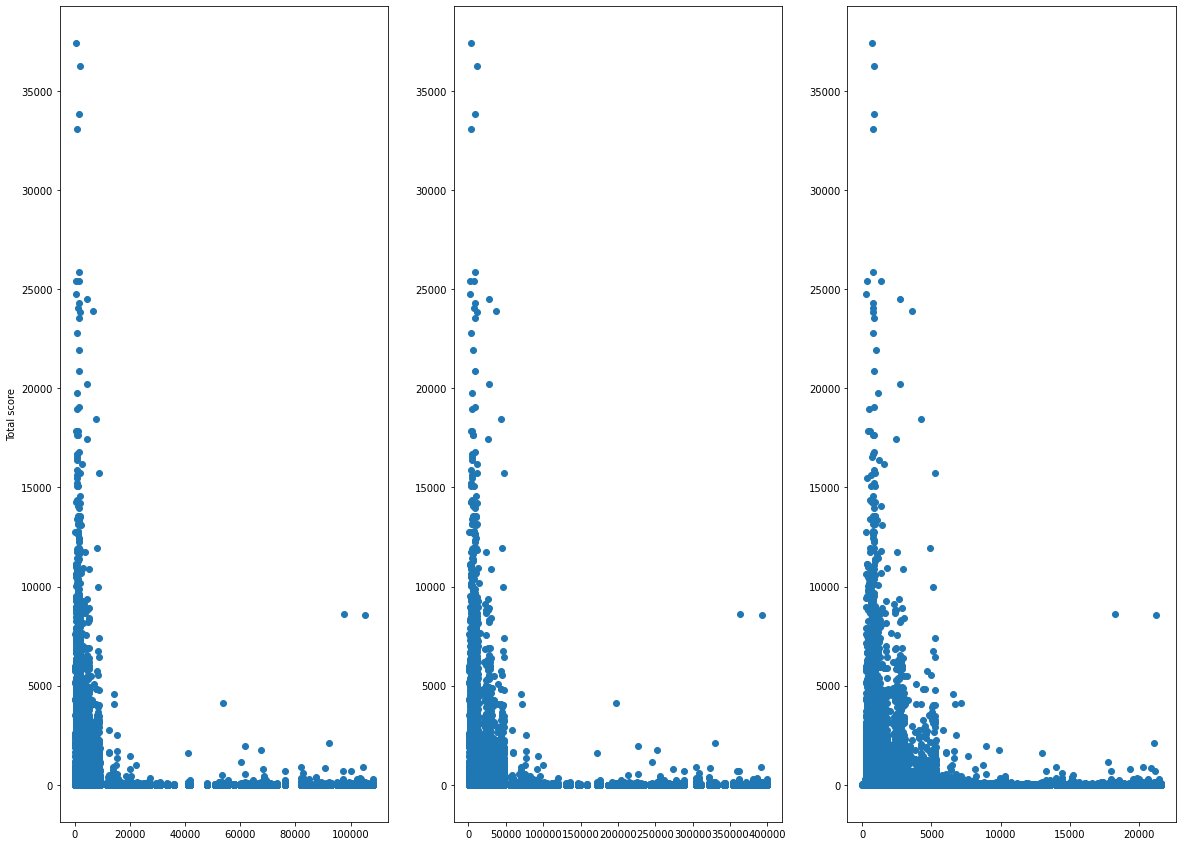

In [92]:
fig, axes = plt.subplots(1,3)

axs = axes.ravel()
fig.set_size_inches((20,15))
axs[0].scatter(df_model.retweet, df_model.score)
axs[0].set_ylabel('Total score')
axs[1].scatter(df_model.likes, df_model.score)
axs[2].scatter(df_model.num, df_model.score)
df_model.score.max()

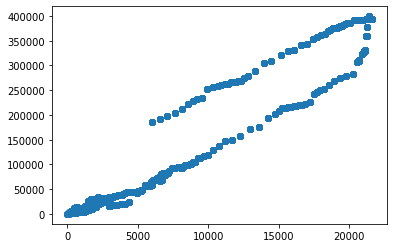

In [95]:
plt.scatter(df_model.num, df_model.likes)

## Training the Model

Since the dataset is quite imbalanced (~3% popular posts), I decided to use oversampling to make a balanced dataset. One thing I realized is that I should not oversample before splitting the dataset into training/testing sets, as the testing datapoints will have leaked into the training set. 

By extension, the cross validation also shouldn't be performed if we oversample. I did not think of that when writing this block, so you can see that the cross validation gives increasingly good results as the complexity increases. 

In [22]:
df_features = df_model.drop(columns = ['title','author','ext_link','created','body','post_type', 'hour','day','score'])

X = df_features.drop(columns = ['Popular'])
y = df_model['Popular']

X_train, X_test, y_train, y_test = X[X['month'] < 4].drop(columns = ['month']), X[X['month'] >= 4].drop(columns = ['month']), y[X['month'] < 4], y[X['month'] >= 4]

X_test.head()
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y)

,title_emoji,body_emoji,title_length,body_length,title_EQ,body_EQ,title_UL,body_UL,log_num,mean_upvotes,prime_time,weekend,figures,outside_link
76718,0,0,4,69,0,0,0.166667,0.041237,0.000000,1.000000,0,0,0,0
76719,1,0,18,0,2,0,0.048780,0.000000,0.000000,1.000000,0,0,1,0
76720,0,9,3,65,0,0,0.090909,0.017483,0.301030,10.000000,0,0,0,0
76721,0,0,12,0,0,0,0.317073,0.000000,0.477121,10.000000,0,0,1,0
76722,0,3,3,23,0,1,0.090909,0.102804,1.819544,20.848485,0,0,0,0


### Modulizing the training process.

I will write a function to automate the training process, including cross validation.

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import clone

In [28]:
def trainingImbalanced(gridModel, X_train, y_train, weight_factor):
    
    weights = np.ones(y_train.shape)
    
    weights[y_train == 1] = weight_factor/np.mean(y_train)
    gridModel.fit(X_train, y_train, sample_weight = weights)


    
def trainingImbalancedAug(gridModel, X_train, y_train):
    X_0 = X_train[y_train == 0,:]
    X_1 = X_train[y_train == 1,:]
    
    augInd = np.random.choice(X_1.shape[0], size = X_0.shape[0], replace = True)
    
    X_0 = np.concatenate([X_0, np.zeros((X_0.shape[0],1))], axis = 1)
    X_1Aug = np.concatenate([X_1[augInd], np.ones((X_0.shape[0],1))], axis = 1)
    
    X_comb = np.concatenate([X_0, X_1Aug], axis = 0)
    
    gridModel.fit(X_comb[:,:-1], X_comb[:,-1])

def trainingSingle(model, X_train, y_train):
    weights = np.ones(y_train.shape)
    
    weights[y_train == 1] = 1/np.mean(y_train)
    
    model.fit(X_train, y_train, sample_weight = weights)
    
    
    
def scaleAndTrainTest(gridModel, X_train, y_train, X_test, weight_factor):
    scaler = StandardScaler()
    
    X_transformed = scaler.fit_transform(X_train)
    
    
    trainingImbalanced(gridModel, X_train, y_train, weight_factor)
    
    
    X_testTrans = scaler.transform(X_test)
    
    return gridModel.predict(X_testTrans), gridModel.predict_proba(X_testTrans)[:,1]

def scaleAndTrainTestCalibrate(gridModel, X_train, y_train, X_test, weight_factor):
    scaler = StandardScaler()
    
    X_transformed = scaler.fit_transform(X_train)
    
    X_train_train, X_val, y_train_train, y_val = train_test_split(X_transformed, y_train, test_size = 0.1, stratify = y_train)
    
    trainingImbalanced(gridModel, X_train_train, y_train_train, weight_factor)
    
    calibrated = CalibratedClassifierCV(gridModel, method = 'isotonic', cv = 'prefit')
    
    calibrated.fit(X_val, y_val)
    
    X_testTrans = scaler.transform(X_test)
    
    #return gridModel.predict(X_testTrans), gridModel.predict_proba(X_testTrans)[:,1]
    return calibrated.predict(X_testTrans), calibrated.predict_proba(X_testTrans)[:,1]

def trainAndShowConfusionMatrix(gridModel, X_train, y_train, X_test, y_test, weight_factor = 1):
    yPred, yProb = scaleAndTrainTestCalibrate(gridModel, X_train, y_train, X_test, weight_factor)

    #trainingSingle(rf, X_train, y_train)
    print(confusion_matrix(y_test, yPred))
    try:
        print(gridModel.best_estimator_)
    except:
        pass

    prec, rec, threshold = precision_recall_curve(y_test, yProb)
    
    plt.plot(prec,rec)
    plt.grid()
    plt.show()
    return prec, rec, threshold


[[26798     0]
 [ 1892     0]]
DecisionTreeClassifier(max_depth=4)


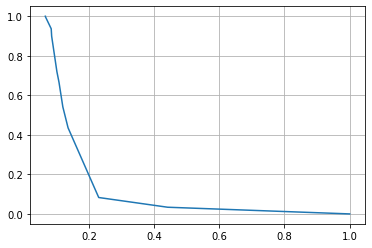

In [25]:
tree_clf = GridSearchCV(DecisionTreeClassifier(), param_grid = {'max_depth': range(4,7)}, scoring = 'precision')

prec, rec, _ = trainAndShowConfusionMatrix(tree_clf, X_train, y_train, X_test, y_test,1)


[[18953  7845]
 [ 1055   837]]
DecisionTreeClassifier(max_depth=5)


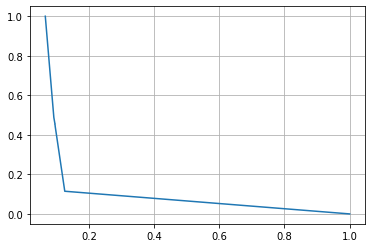

In [27]:
tree_clf = GridSearchCV(DecisionTreeClassifier(), param_grid = {'max_depth': range(4,7)}, scoring = 'precision')

prec, rec, _ = trainAndShowConfusionMatrix(tree_clf, X_train, y_train, X_test, y_test,1)

In [73]:
tree_clf = GridSearchCV(DecisionTreeClassifier(), param_grid = {'max_depth': range(4,7)}, cv = TimeSeriesSplit().split(X_train), scoring = 'f1')

prec, rec, _ = trainAndShowConfusionMatrix(tree_clf, X_train, y_train, X_test, y_test,1)


IndexError: index 69046 is out of bounds for axis 0 with size 69046

[[26789     9]
 [ 1864    28]]
RandomForestClassifier(max_depth=7)


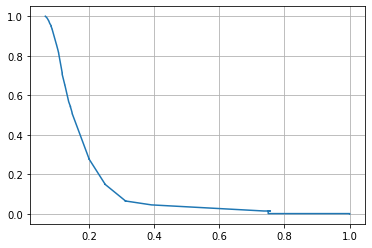

(array([0.06594632, 0.07048276, 0.07048541, 0.07048805, 0.0704907 ,
        0.07049334, 0.07049599, 0.07315926, 0.07693591, 0.07693912,
        0.07694874, 0.07695195, 0.07950484, 0.08326026, 0.0836785 ,
        0.0836824 , 0.08368629, 0.08364364, 0.08364754, 0.08365143,
        0.08365532, 0.08680504, 0.0868093 , 0.08681356, 0.08681782,
        0.10069206, 0.10069834, 0.1007109 , 0.10071718, 0.10485814,
        0.1069567 , 0.10696414, 0.10697157, 0.10697901, 0.10727298,
        0.11764194, 0.11765217, 0.11766241, 0.11767264, 0.11768287,
        0.11769311, 0.11770335, 0.11785998, 0.11787039, 0.1260745 ,
        0.1260874 , 0.12615196, 0.13772762, 0.14275814, 0.14277793,
        0.14279773, 0.14281753, 0.14283733, 0.14327608, 0.14329609,
        0.14317642, 0.14319642, 0.14321643, 0.14323644, 0.14325646,
        0.14327649, 0.14329652, 0.14317673, 0.14801279, 0.14788303,
        0.14844596, 0.14846891, 0.14849188, 0.14851485, 0.20053476,
        0.20061139, 0.20068807, 0.20038241, 0.20

In [29]:
rf_clf = GridSearchCV(RandomForestClassifier(), param_grid = {'max_depth': range(5,9)}, scoring = 'roc_auc')
trainAndShowConfusionMatrix(rf_clf, X_train, y_train, X_test, y_test, 1)

[[18910  8619]
 [  390   771]]
RandomForestClassifier(max_depth=5)


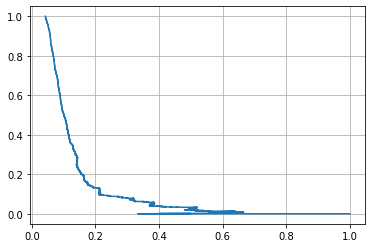

(array([0.0420515 , 0.04201681, 0.04201833, ..., 0.5       , 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99138674e-01, 9.99138674e-01, ...,
        8.61326443e-04, 8.61326443e-04, 0.00000000e+00]),
 array([0.24237429, 0.24237566, 0.24240115, ..., 0.93081375, 0.93139905,
        0.93286655]))

In [38]:
rf_clf = GridSearchCV(RandomForestClassifier(), param_grid = {'max_depth': range(5,9)}, cv = TimeSeriesSplit().split(X_train), scoring = 'f1')
trainAndShowConfusionMatrix(rf_clf, X_train, y_train, X_test, y_test, 1)

In [30]:
Name = []
Importance = []
for name, importance in zip(X_train.columns, rf_clf.best_estimator_.feature_importances_):
    Name.append(name)
    Importance.append(importance)

df_imp = pd.DataFrame({'Name': Name, 'Importance': Importance})    

df_imp.sort_values('Importance', ascending = False)

,Name,Importance
2,title_length,0.274045
9,mean_upvotes,0.215008
3,body_length,0.145384
12,figures,0.082140
1,body_emoji,0.067912
5,body_EQ,0.041123
7,body_UL,0.039700
6,title_UL,0.037846
8,log_num,0.027382
0,title_emoji,0.023428


In [88]:
lr_clf = GridSearchCV(LogisticRegression(), param_grid = {'penalty': ('l2','none'), 'C': (0.1,0.5,1,2)})

trainAndShowConfusionMatrix(lr_clf, X_train, y_train, X_test, y_test,1.5)


C:\Users\kungc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\kungc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\kungc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\kungc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:1320: UserWar

[[10542  9924]
 [  106   510]]
LogisticRegression(C=0.1, penalty='none')


SVM is simply too slow for >100K entries, so we should not use that.

```Python

svm_clf = GridSearchCV(SVC(), param_grid = {'kernel' : ('linear', 'poly', 'rbf'), 'degree' : (2,3,4)})

trainAndShowConfusionMatrix(svm_clf, X_train, y_train, X_test, y_test)

```

C:\Users\kungc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[[26352  1177]
 [ 1034   127]]
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)


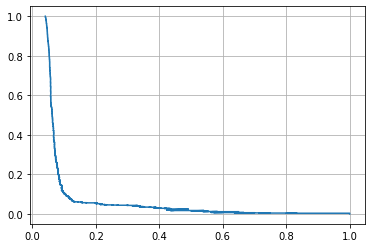

(array([0.04064984, 0.04061625, 0.04061767, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99138674e-01, 9.99138674e-01, ...,
        1.72265289e-03, 8.61326443e-04, 0.00000000e+00]),
 array([2.7596023e-05, 2.7617767e-05, 2.7779215e-05, ..., 9.9917102e-01,
        9.9935549e-01, 9.9984694e-01], dtype=float32))

In [60]:
xgb = XGBClassifier(verbosity=0)

gs = GridSearchCV(xgb, param_grid={'max_depth': [1, 5, 10]}, cv = TimeSeriesSplit().split(X_train))

trainAndShowConfusionMatrix(gs, X_train, y_train, X_test, y_test,1)

[[19414  8115]
 [  434   727]]


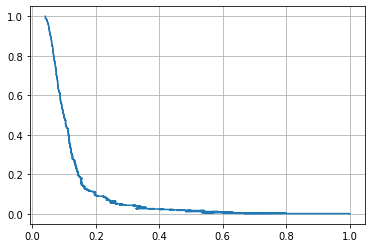

(array([0.04047835, 0.04044489, 0.0404463 , ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99138674e-01, 9.99138674e-01, ...,
        1.72265289e-03, 8.61326443e-04, 0.00000000e+00]),
 array([0.48253816, 0.48317543, 0.48563444, ..., 0.50648   , 0.50714049,
        0.50749018]))

In [61]:
ada_clf = AdaBoostClassifier(n_estimators= 500)

trainAndShowConfusionMatrix(ada_clf, X_train, y_train, X_test, y_test)

[[19986  7543]
 [  457   704]]


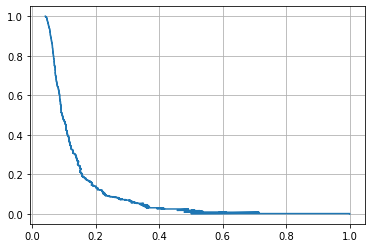

(array([0.04092784, 0.04089403, 0.04089547, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99138674e-01, 9.99138674e-01, ...,
        1.72265289e-03, 8.61326443e-04, 0.00000000e+00]),
 array([0.01060684, 0.0106169 , 0.01062908, ..., 0.99055188, 0.99089427,
        0.99324922]))

In [43]:
gb_clf = GradientBoostingClassifier(n_estimators= 500)

trainAndShowConfusionMatrix(gb_clf, X_train, y_train, X_test, y_test,1)


[[19271  8258]
 [  669   492]]


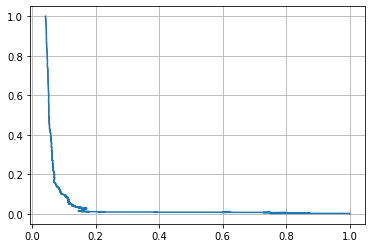

(array([0.04083571, 0.04080197, 0.0408034 , ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99138674e-01, 9.99138674e-01, ...,
        1.72265289e-03, 8.61326443e-04, 0.00000000e+00]),
 array([0.31808431, 0.31817703, 0.31819226, ..., 0.65863907, 0.66440391,
        0.67552931]))

In [62]:
voting_clf = VotingClassifier(
                [('ada',AdaBoostClassifier(n_estimators= 500)),
                 ('gb',GradientBoostingClassifier(n_estimators= 500)),
                ('rf',RandomForestClassifier(max_depth = 5))],
                voting = "soft")
trainAndShowConfusionMatrix(voting_clf, X_train, y_train, X_test, y_test,1)

### Probability Calibration

Most models are not calibrated in probability, and I would like to see if calibrating the probability can help with the PR curve.


In [43]:
def trainingImbalanced(gridModel, X_train, y_train, weight_factor):
    
    weights = np.ones(y_train.shape)
    
    weights[y_train == 1] = weight_factor/np.mean(y_train)
    gridModel.fit(X_train, y_train, sample_weight = weights)
    
    
    
def trainAndNotCalibrate(gridModel, X_train, y_train, X_test, weight_factor):
    scaler = StandardScaler()
    
    X_transformed = scaler.fit_transform(X_train)
    
    
    trainingImbalanced(gridModel, X_train, y_train, weight_factor)
    
    
    X_testTrans = scaler.transform(X_test)
    
    return gridModel.predict_proba(X_testTrans)[:,1]

def trainAndCalibrate(gridModel, X_train, y_train, X_test, weight_factor):
    scaler = StandardScaler()
    
    X_transformed = scaler.fit_transform(X_train)
    
    X_train_train, X_val, y_train_train, y_val = train_test_split(X_transformed, y_train, test_size = 0.1, stratify = y_train)
    
    trainingImbalanced(gridModel, X_train_train, y_train_train, weight_factor)
    
    calibrated = CalibratedClassifierCV(gridModel, method = 'isotonic', cv = 'prefit')
    
    calibrated.fit(X_val, y_val)
    
    X_testTrans = scaler.transform(X_test)
    
    #return gridModel.predict(X_testTrans), gridModel.predict_proba(X_testTrans)[:,1]
    return calibrated.predict_proba(X_testTrans)[:,1]

def trainAndCompareCalibration(gridModel, X_train, y_train, X_test, y_test, modelName, weight_factor = 1):
    cloned = clone(gridModel)
    
    yProbCal = trainAndCalibrate(cloned, X_train, y_train, X_test, weight_factor)
    
    cloned = clone(gridModel)
    
    yProbUnCal = trainAndNotCalibrate(cloned, X_train, y_train, X_test, weight_factor)
    

    precCal, recCal, thresholdCal = precision_recall_curve(y_test, yProbCal)
    plt.plot(precCal,recCal, label = f'Calibrated {modelName}')
    
    precUnCal, recUnCal, threshold = precision_recall_curve(y_test, yProbUnCal)
    plt.plot(precUnCal,recUnCal, label = f'Uncalibrated {modelName}')    
    
    plt.grid()
    plt.legend()
    plt.show()
    
    return thresholdCal


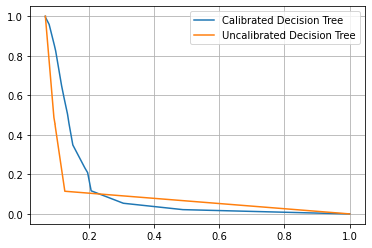

array([0.        , 0.00550964, 0.02113739, 0.03012048, 0.0376    ,
       0.05263158, 0.06164384, 0.08552632, 0.09401709, 0.10208817,
       0.11940299, 0.15254237, 0.19135802, 0.29166667, 0.55555556])

In [44]:
tree_clf = GridSearchCV(DecisionTreeClassifier(), param_grid = {'max_depth': range(4,7)}, scoring = 'precision')

trainAndCompareCalibration(tree_clf, X_train, y_train, X_test, y_test,'Decision Tree', 1)

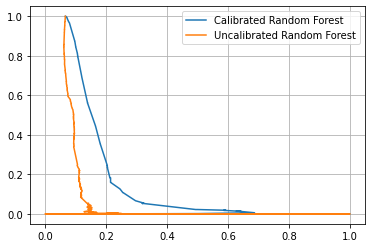

In [41]:
rf_clf = GridSearchCV(RandomForestClassifier(), param_grid = {'max_depth': range(5,9)}, scoring = 'f1')
trainAndCompareCalibration(rf_clf, X_train, y_train, X_test, y_test, 'Random Forest', 1)

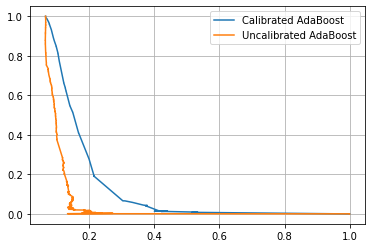

In [42]:
ada_clf = AdaBoostClassifier(n_estimators= 500)

trainAndCompareCalibration(ada_clf, X_train, y_train, X_test, y_test, 'AdaBoost')

### Use the important features to train again

In [33]:
df_features[df_imp.sort_values('Importance', ascending = False).Name.values[:15]].head()

,title_length,mean_upvotes,body_length,body_emoji,figures,body_EQ,title_UL,body_UL,log_num,title_emoji,title_EQ,day_3,day_6,day_4,outside_link
0,8,1.0,11,3,0,0,0.333333,0.278689,0.00000,6,0,0,0,0,0
1,10,6.0,17,11,0,2,1.000000,0.105691,0.00000,1,0,0,0,0,0
2,4,1.0,86,1,0,2,0.222222,0.048387,0.00000,0,0,0,0,0,0
3,14,4.0,43,5,0,1,0.166667,0.040724,0.30103,3,0,0,1,0,0
4,5,14.0,0,0,0,0,0.080000,0.000000,0.00000,0,5,0,0,0,1


In [34]:
impColumns = df_imp.sort_values('Importance', ascending = False).Name.values[:15]

X = df_features[impColumns]
y = df_model['Popular']

X_train, X_test, y_train, y_test = X[df_model['month'] < 4], X[df_model['month'] >= 4], y[df_model['month'] < 4], y[df_model['month'] >= 4]



[[17306 10223]
 [  350   811]]
DecisionTreeClassifier(max_depth=5)


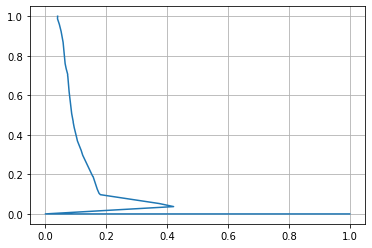

(array([0.04046706, 0.04013308, 0.04623053, 0.05195561, 0.0585094 ,
        0.06515643, 0.0685967 , 0.0735426 , 0.07350009, 0.07397912,
        0.07831786, 0.0867069 , 0.09178826, 0.09168371, 0.09499719,
        0.10295804, 0.1055091 , 0.1143445 , 0.11792602, 0.12286325,
        0.15574348, 0.15691869, 0.17078916, 0.17664234, 0.18108974,
        0.37423313, 0.42156863, 0.        , 1.        ]),
 array([1.        , 0.9870801 , 0.95865633, 0.92334195, 0.86821705,
        0.76055125, 0.73471146, 0.70628768, 0.69853575, 0.69595177,
        0.61757106, 0.50732127, 0.46597761, 0.46339363, 0.43669251,
        0.38673557, 0.36950904, 0.33505599, 0.32127476, 0.29715762,
        0.19035314, 0.18949182, 0.12489233, 0.1042205 , 0.09732989,
        0.05254091, 0.03703704, 0.        , 0.        ]),
 array([0.        , 0.08324463, 0.22763541, 0.35170271, 0.42229311,
        0.42667957, 0.47753755, 0.48899104, 0.52769799, 0.54166478,
        0.57820423, 0.58671193, 0.59405312, 0.60689033, 0.68385087,


In [35]:
tree_clf = GridSearchCV(DecisionTreeClassifier(), param_grid = {'max_depth': range(4,7)}, scoring = 'precision')

trainAndShowConfusionMatrix(tree_clf, X_train, y_train, X_test, y_test,1)


Using the important features, the result is not too much different. We might be able to only use those and add in other ones.

### Incorporate Twitter Data

We will add in twitter information as our features. We can collect the number of total retweets, likes, and tweets for the past 3 days. Let's see if those information will be useful.

In [37]:
df_twitter = pd.read_csv('../Twitter Data/GME_TWEETS_individual.csv')

df_twitter.head()

C:\Users\kungc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (0,2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,author_id,text,id,Date,retweet,likes,reply,num,image,video,gif
0,1286967581337726981,GameStop $GME is more of a momentum play than ...,1342263553156284416,2020-12-25 00:00:00,0.0,9.0,1.0,1.0,0.0,0.0,0.0
1,914214567152160768,$GME GameStop Corporation Comm Top stock up 63...,1342264009693798401,2020-12-25 00:00:00,0.0,2.0,0.0,1.0,0.0,0.0,0.0
2,1288287907116195840,GameStop Corp. Class A Shares Close the Week 4...,1342440366721658880,2020-12-25 12:00:00,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,39306174,Don't Touch GameStop Stock Until This Happens ...,1342479907696345089,2020-12-25 14:00:00,2.0,2.0,0.0,1.0,0.0,0.0,0.0
4,914214567152160768,$GME GameStop Corporation Comm Top stock up 63...,1342628773842313216,2020-12-26 00:00:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [38]:
df_twitter.Date = df_twitter.Date.astype('str')

In [39]:
def convertToUNIX(date):
    try:
        result = np.datetime64(date).astype('datetime64[s]').astype('int')
    except:
        result = 0
    return result


In [40]:
df_twitter['UNIX'] = df_twitter['Date'].apply(convertToUNIX)

In [6]:
df_grouped = df_twitter.groupby('Date').sum()

In [7]:
df_grouped.head()

,retweet,likes,reply,num,image,video,gif
Date,,,,,,,
0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
2020-12-25 00:00:00,0.0,11.0,1.0,2.0,0.0,0.0,0.0
2020-12-25 12:00:00,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2020-12-25 14:00:00,2.0,2.0,0.0,1.0,0.0,0.0,0.0
2020-12-26 00:00:00,1.0,19.0,4.0,3.0,0.0,0.0,0.0


In [10]:
df_grouped['Date'] = df_grouped.index

In [13]:
df_grouped['UNIX'] = df_grouped.Date.apply(convertToUNIX)

In [14]:
df_grouped.head()

,retweet,likes,reply,num,image,video,gif,Date,UNIX
Date,,,,,,,,,
0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0,-2037677056
2020-12-25 00:00:00,0.0,11.0,1.0,2.0,0.0,0.0,0.0,2020-12-25 00:00:00,1608854400
2020-12-25 12:00:00,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2020-12-25 12:00:00,1608897600
2020-12-25 14:00:00,2.0,2.0,0.0,1.0,0.0,0.0,0.0,2020-12-25 14:00:00,1608904800
2020-12-26 00:00:00,1.0,19.0,4.0,3.0,0.0,0.0,0.0,2020-12-26 00:00:00,1608940800


In [29]:
def getTwitterInfo(timestamp, df, gap = 86400*3):
    df_sum = df[(df['UNIX'] < timestamp) & (df['UNIX'] >= timestamp - gap)].sum()
    
    return df_sum.retweet, df_sum.likes, df_sum.num


In [70]:
for i in range(df_features.shape[0]):
    df_model.loc[i,['retweet', 'likes', 'num']] = getTwitterInfo(df_model.loc[i,'created'], df_grouped)
    

In [71]:
df_model.head()

,title,author,ext_link,created,body,score,Popular,title_emoji,body_emoji,title_length,...,day_1,day_2,day_3,day_4,day_5,day_6,month,retweet,likes,num
0,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqfajb/y...,1609786946,After watching this I took a position RIGHT AW...,6,0,6,3,8,...,0,0,0,0,0,0,1,4.0,29.0,11.0
1,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqvp7l/t...,1609841999,This guy explained exactly how to take a posit...,2,0,1,11,10,...,1,0,0,0,0,0,1,3.0,10.0,9.0
2,ICR conference (11th Jan),nicky94,https://www.reddit.com/r/GME/comments/krnthg/i...,1609939549,Any speculation or ideas on what Gamestop migh...,14,0,0,1,4,...,0,1,0,0,0,0,1,3.0,23.0,12.0
3,"GME is FINALLY going to the moon, this technic...",TitsDownOnly,https://www.reddit.com/r/GME/comments/kuo3w1/g...,1610315957,"After some downwards movement, I think everyb...",11,0,3,5,14,...,0,0,0,0,0,1,1,8.0,24.0,19.0
4,Ryan Cohen appointed to board!!!!?,nicky94,https://news.gamestop.com/news-releases/news-r...,1610368592,,18,0,0,0,5,...,0,0,0,0,0,0,1,18.0,63.0,50.0


In [96]:
df_featuresTwitter = df_model.drop(columns = ['title','author','ext_link','created','body','post_type', 'hour','day','score','retweet','likes'])

X = df_featuresTwitter.drop(columns = ['Popular'])
y = df_model['Popular']

X_train, X_test, y_train, y_test = X[X['month'] < 4].drop(columns = ['month']), X[X['month'] >= 4].drop(columns = ['month']), y[X['month'] < 4], y[X['month'] >= 4]

X_train.head()

,title_emoji,body_emoji,title_length,body_length,title_EQ,body_EQ,title_UL,body_UL,figures,outside_link,...,hour_22,hour_23,day_0,day_1,day_2,day_3,day_4,day_5,day_6,num
0,6,3,8,11,0,0,0.333333,0.278689,0,0,...,0,0,1,0,0,0,0,0,0,11.0
1,1,11,10,17,0,2,1.000000,0.105691,0,0,...,0,0,0,1,0,0,0,0,0,9.0
2,0,1,4,86,0,2,0.222222,0.048387,0,0,...,0,0,0,0,1,0,0,0,0,12.0
3,3,5,14,43,0,1,0.166667,0.040724,0,0,...,0,0,0,0,0,0,0,0,1,19.0
4,0,0,5,0,5,0,0.080000,0.000000,0,1,...,0,0,1,0,0,0,0,0,0,50.0


In [98]:
rf_clf = GridSearchCV(RandomForestClassifier(), param_grid = {'max_depth': range(5,9)}, scoring = 'precision')
trainAndShowConfusionMatrix(rf_clf, X_train, y_train, X_test, y_test, 1)

[[14990 12539]
 [  279   882]]
RandomForestClassifier(max_depth=5)


In [99]:
Name = []
Importance = []
for name, importance in zip(X_train.columns, rf_clf.best_estimator_.feature_importances_):
    Name.append(name)
    Importance.append(importance)

df_imp = pd.DataFrame({'Name': Name, 'Importance': Importance})

df_imp.sort_values('Importance', ascending = False)

,Name,Importance
2,title_length,0.268663
3,body_length,0.175168
41,num,0.151255
1,body_emoji,0.112284
5,body_EQ,0.066136
8,figures,0.054990
7,body_UL,0.030026
0,title_emoji,0.022381
6,title_UL,0.020079
4,title_EQ,0.014393


In [78]:
impColumns = df_imp.sort_values('Importance', ascending = False).Name.values[:15]

X = df_model[impColumns]
y = df_model['Popular']

X_train, X_test, y_train, y_test = X[df_model['month'] < 4], X[df_model['month'] >= 4], y[df_model['month'] < 4], y[df_model['month'] >= 4]

rf_clf = GridSearchCV(RandomForestClassifier(), param_grid = {'max_depth': range(5,9)}, scoring = 'precision')
trainAndShowConfusionMatrix(rf_clf, X_train, y_train, X_test, y_test, 1)

[[11049 16480]
 [  144  1017]]
RandomForestClassifier(max_depth=5)


In [79]:
ada_clf = AdaBoostClassifier(n_estimators= 500)

trainAndShowConfusionMatrix(ada_clf, X_train, y_train, X_test, y_test)

[[16695 10834]
 [  383   778]]


### Precision-recall curve

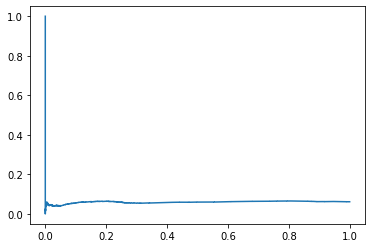

In [34]:
plt.plot(rec,prec)

In [40]:
max(prec[:-1])

0.06568455196648196

In [45]:
yPred = rf_clf.predict(X_test)

precision_score(y_test, yPred)

0.06148483792262112